## Atividade II - Hands on Introduction to Machine Learning

Aluno: Luis Felipe dos Santos Ribeiro
Rio de janeiro, 28 de março de 2022

1) Importação de pacotes

In [47]:
import pandas as pd
import numpy as np 
import scipy.io as sio 
import matplotlib.pyplot as plt 
from os import getcwd
from os.path import join 

2. Leitura de datasets

In [48]:
mat_contents = sio.loadmat('data3SS2009.mat')
dataset = mat_contents['dataset']
n_samples, n_channels, n_cases = dataset.shape # N, Chno, Nc
y = mat_contents['labels'].reshape(n_cases)

Ch1 = pd.DataFrame(dataset[:,0,:])
Ch2 = pd.DataFrame(dataset[:,1,:])
Ch3 = pd.DataFrame(dataset[:,2,:])
Ch4 = pd.DataFrame(dataset[:,3,:])
Ch5 = pd.DataFrame(dataset[:,4,:])

## Modelo Autoregressivo

Modelo autoregressivo para determinação de coeficientes para aproximação da curva:

- y(t) = c_0 + x1 * t1 + ... xn*tn, com n = número de lags

In [49]:
from statsmodels.tsa.ar_model import AutoReg
Feat = []
lags = 30
for i in range(0,n_cases):
    ar_model_Ch1 = AutoReg(Ch1[i].values, lags = lags).fit()
    ar_model_Ch2 = AutoReg(Ch1[i].values, lags = lags).fit()
    ar_model_Ch3 = AutoReg(Ch1[i].values, lags = lags).fit()
    ar_model_Ch4 = AutoReg(Ch1[i].values, lags = lags).fit()
    ar_models = np.concatenate([ar_model_Ch1.params, ar_model_Ch2.params, ar_model_Ch3.params, ar_model_Ch4.params])
    Feat.append(ar_models)


# Redução da dimensionalidade - PCA

1. Redução para 2 dimensões:

Text(0, 0.5, 'Componentes Principais Primários')

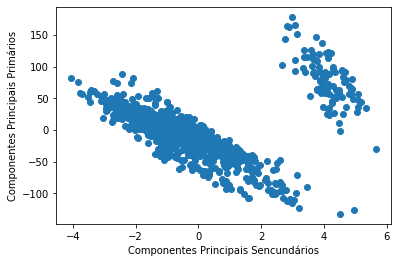

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit_transform(Feat)
plt.figure()
plt.scatter(pca[:,1], pca[:,0])
plt.xlabel('Componentes Principais Sencundários')
plt.ylabel('Componentes Principais Primários')


2. Redução para 3 dimensões

c:\Users\luissantos\OneDrive - puc-rio.br\PhD\Diciplinas\MachineLearningProjects\venv\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 0.5, 'Componentes Principais Primários')

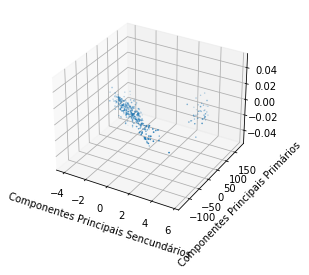

In [51]:
pca = PCA(n_components = 3).fit_transform(Feat)
plt.figure()
plt.subplot(projection='3d')
plt.scatter(pca[:,1], pca[:,0], pca[:,2])
plt.xlabel('Componentes Principais Sencundários')
plt.ylabel('Componentes Principais Primários')

## Softmax Regression 

1. Novos pacotes

In [53]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

2. Escalando modelo para valores no intervalo (-1,1)

In [54]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
Feat_scaler = min_max_scaler.fit_transform(Feat)
Y = mat_contents['labels'].reshape(n_cases)

3. Criando o modelo:

In [55]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.7, random_state = 0 )
modelo_tot = linear_model.LogisticRegression()
modelo_tot.fit(x_train, y_train)

c:\Users\luissantos\OneDrive - puc-rio.br\PhD\Diciplinas\MachineLearningProjects\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

4. Predições e aferições quanto a qualidade do modelo:

In [56]:
y_pred = modelo_tot.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm) 
print(ac)

[[ 4  6  7  0  0  3  0  3  0  0  0  4  1  0  5  1  0]
 [ 2  3  1  0  0  5  0  4  1  0  0  2  0  0 13  0  0]
 [ 1  0  7  0  0  2  1  1  1  0  0  9  3  1  4  0  1]
 [ 0  0  0 32  0  0  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 33  2  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 28  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  3 25  2  0  0  2  0  1  0  0  0]
 [ 0  1  0  0  3  3  1  1 26  0  0  1  0  0  1  0  0]
 [ 0  0  0  8  0  0  0  0  0 34  0  0  0  0  0  0  0]
 [ 0  5  6  0  0  3  2  3  1  0  0 13  0  1  2  0  1]
 [ 2  2  1  0  1  5  0  5  2  0  0 11  1  0  0  0  2]
 [ 2  2  6  0  0  2  0  1  2  0  0  3  3  2  9  1  2]
 [ 0  6  2  0  1  4  0  3  0  0  0  3  6 10  3  0  0]
 [ 1  7  1  0  0  1  0  1  0  0  1  1  0  1 16  1  0]
 [ 2  7  7  0  0  1  0  5  0  0  0  6  1  1  5  1  2]
 [ 0  1  4  0  0  4  1  2  0  0  0  9  1  0  4  0  9]]
0.47058823529411764


## Softmax usando outro método para escalar as variáveis:

In [91]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df = sc.fit_transform(Feat)

x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size = 0.7, random_state = 0 )
modelo_tot = linear_model.LogisticRegression()
modelo_tot.fit(x_train, y_train)

y_pred = modelo_tot.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm) 
print(ac)

[[10  5  3  0  0  4  0  0  0  0  1  0  0  1  1  6  3]
 [ 6 13  0  0  0  2  0  0  0  0  0  1  0  1  8  0  0]
 [ 0  0  8  0  0  0  0  2  2  0  2  5  4  0  3  0  5]
 [ 0  0  0 33  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0 28  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  1 29  0  0  1  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 35  0  0  0  1  0  1  0  0]
 [ 0  0  0  5  0  0  0  0  0 37  0  0  0  0  0  0  0]
 [ 1  0  5  0  0  0  1  0  0  0  4 10  1  1  3  2  9]
 [ 2  2  3  0  0  1  0  1  0  0  1 11  4  0  1  1  5]
 [ 0  1  0  0  0  1  0  1  1  0  3  2 10  5  5  3  3]
 [ 0  0  0  0  0  0  0  2  0  0  1  2 10 21  1  0  1]
 [ 1 17  0  0  0  0  0  1  0  0  0  0  1  0 10  1  0]
 [ 3  4  8  0  0  0  0  2  0  0  0  3  3  1  6  5  3]
 [ 0  1  7  0  0  0  1  0  1  0  1  4  4  0  1  1 14]]
0.5747899159663865


c:\Users\luissantos\OneDrive - puc-rio.br\PhD\Diciplinas\MachineLearningProjects\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
